In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb
from bayes_opt import BayesianOptimization
import shap
from bayes_opt import UtilityFunction



d:\projects\Machine_learning\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Import data dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)
data = data.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
data = pd.get_dummies(data, drop_first=False)
data = data.fillna(data.mean())


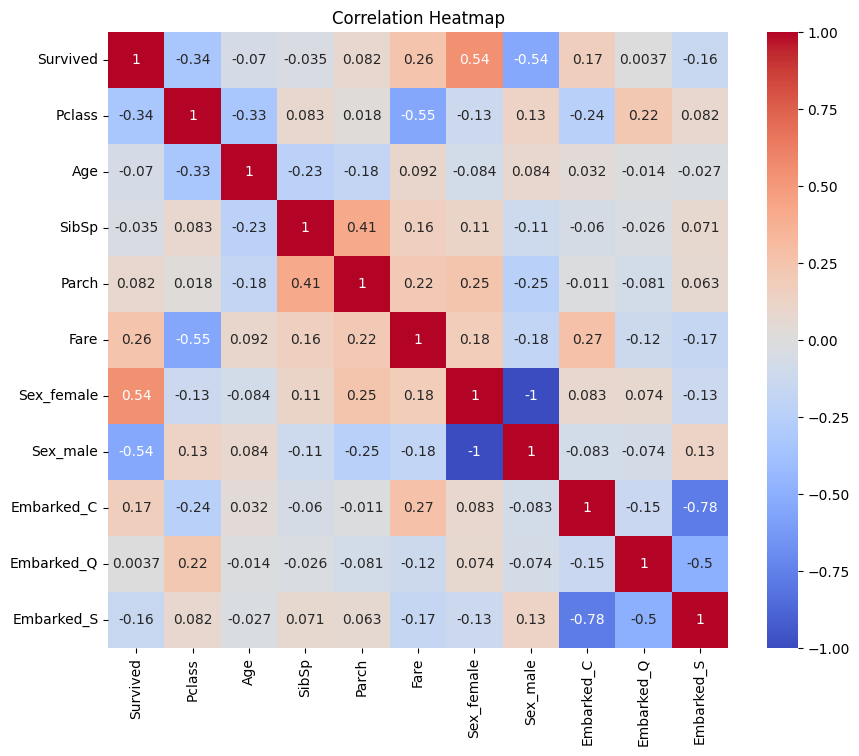

In [3]:

# 2. Correlation heat map plot
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [4]:

# 3. Descriptive analysis
(data.describe())



,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    bool   
 7   Sex_male    891 non-null    bool   
 8   Embarked_C  891 non-null    bool   
 9   Embarked_Q  891 non-null    bool   
 10  Embarked_S  891 non-null    bool   
dtypes: bool(5), float64(2), int64(4)
memory usage: 46.2 KB


In [6]:

# 4. Correlation of target with each feature
target_corr = data.corr()['Survived'].sort_values(ascending=False)
print(target_corr)




Survived      1.000000
Sex_female    0.543351
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.069809
Embarked_S   -0.155660
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64


In [7]:
# Data preprocessing
# data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data['Age'].fillna(data['Age'].mean(), inplace=True)
# data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Convert categorical variables to numeric
# data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

# 5. Train-test split
X = data.drop('Survived', axis=1)
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



C:\Users\user\AppData\Local\Temp\ipykernel_3140\3035107440.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].mean(), inplace=True)


In [8]:
# 6. XGBoost model training using hyperparameter tuning (Bayesian Optimization)
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'n_estimators': 100,
        'learning_rate': 0.1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, predictions)
    return auc

xgb_bo = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'max_depth': (3, 10),
        'gamma': (0, 1),
        'colsample_bytree': (0.3, 0.9)
    },
    random_state=42
)

# Set Gaussian process parameters
xgb_bo.set_gp_params(alpha=1e-3)
# Create an instance of the acquisition function
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# Maximize the acquisition function
xgb_bo.maximize(init_points=10, n_iter=30, acquisition_function=utility)


|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
| 1         | 0.8918    | 0.5247    | 0.9507    | 8.124     |
| 2         | 0.8843    | 0.6592    | 0.156     | 4.092     |
| 3         | 0.8909    | 0.3349    | 0.8662    | 7.208     |
| 4         | 0.8821    | 0.7248    | 0.02058   | 9.789     |
| 5         | 0.8889    | 0.7995    | 0.2123    | 4.273     |
| 6         | 0.887     | 0.41      | 0.3042    | 6.673     |
| 7         | 0.8966    | 0.5592    | 0.2912    | 7.283     |
| 8         | 0.8893    | 0.3837    | 0.2921    | 5.565     |
| 9         | 0.886     | 0.5736    | 0.7852    | 4.398     |
| 10        | 0.8867    | 0.6085    | 0.5924    | 3.325     |
| 11        | 0.8966    | 0.5592    | 0.2912    | 7.283     |
| 12        | 0.892     | 0.5207    | 0.2613    | 7.332     |
| 13        | 0.8967    | 0.5649    | 0.3076    | 7.252     |
| 14        | 0.8913    | 0.6174    | 0.3011    | 7.278     |
| 15    

In [9]:

# Extract the best parameters
params = xgb_bo.max['params']
params['max_depth'] = int(params['max_depth'])



In [10]:
# Train final model
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

# 7. Check AUC, Classification report
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)[:,1]

print('AUC:', roc_auc_score(y_test, predictions_proba))
print(classification_report(y_test, predictions))




AUC: 0.8961389961389962
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



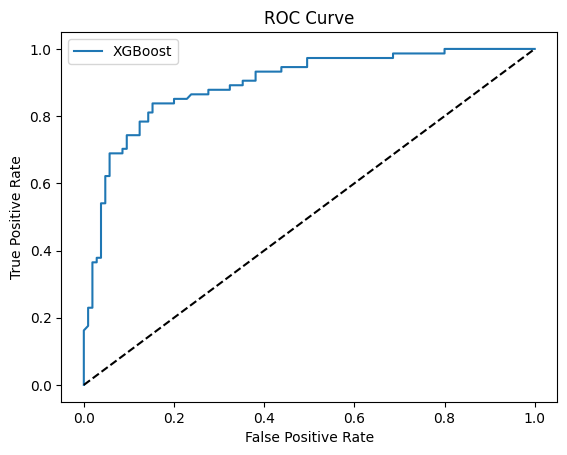

In [11]:

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions_proba)
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()




In [12]:
# 8. Create SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)



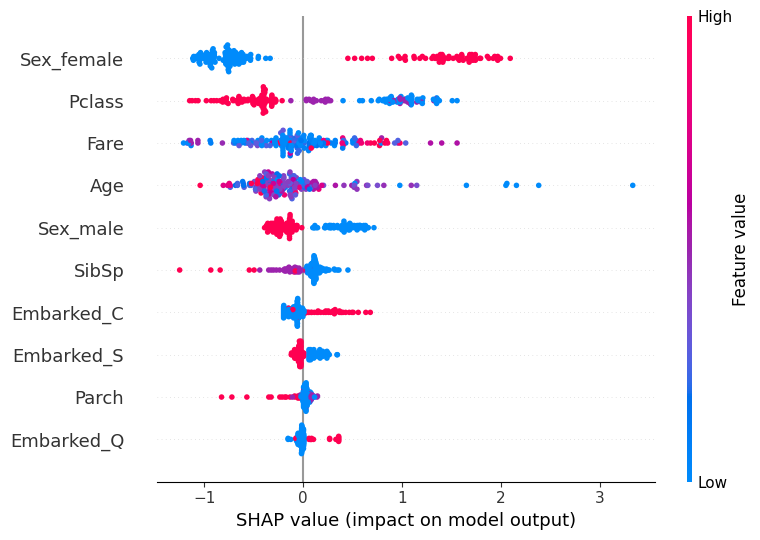

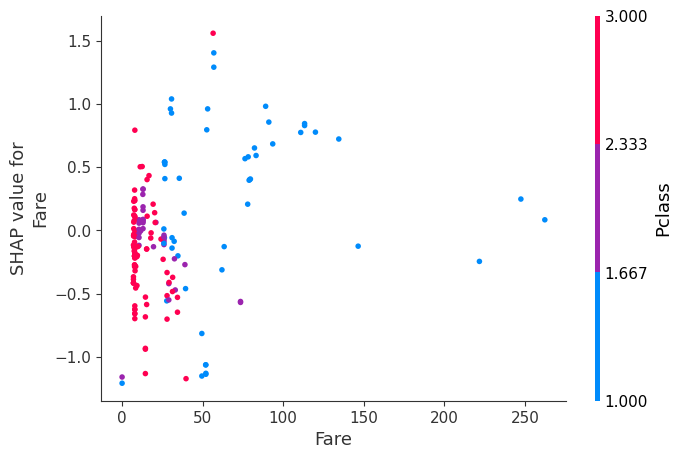

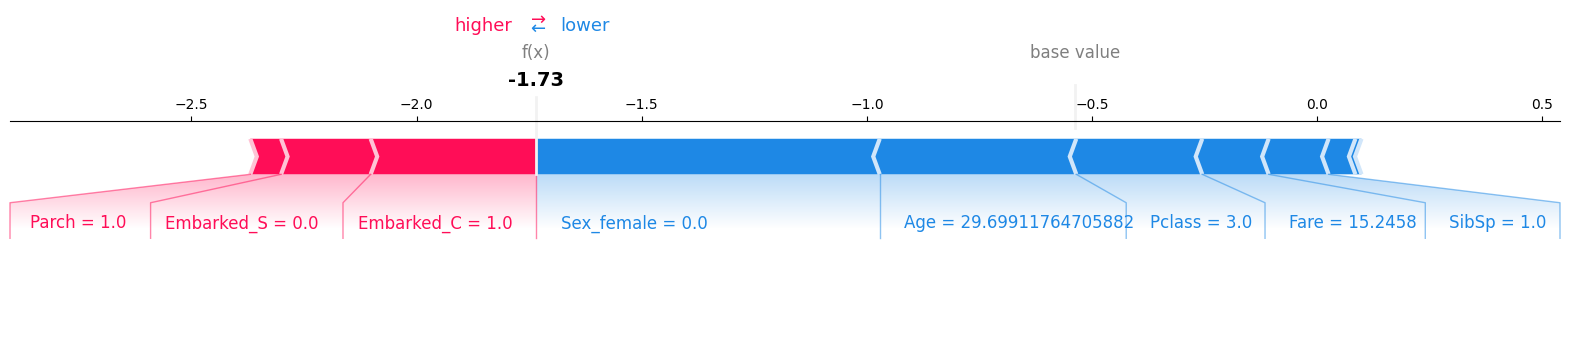

In [13]:
# 9. Explain SHAP values
shap.summary_plot(shap_values, X_test)
shap.dependence_plot("Fare", shap_values, X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)



In [14]:
from sklearn.linear_model import LogisticRegression

# 6. Logistic Regression model training using hyperparameter tuning (Bayesian Optimization)
def lr_evaluate(C, max_iter):
    model = LogisticRegression(C=C, max_iter=int(max_iter), solver='liblinear')
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, predictions)
    return auc

lr_bo = BayesianOptimization(
    f=lr_evaluate,
    pbounds={
        'C': (0.001, 10),  # Regularization parameter
        'max_iter': (50, 300)  # Maximum number of iterations
    },
    random_state=42
)

# Set Gaussian process parameters
lr_bo.set_gp_params(alpha=1e-3)

# Create an instance of the acquisition function
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# Maximize the acquisition function
lr_bo.maximize(init_points=10, n_iter=30, acquisition_function=utility)

# Extract the best parameters
params = lr_bo.max['params']
params['max_iter'] = int(params['max_iter'])

# Train final model
model = LogisticRegression(**params, solver='liblinear')
model.fit(X_train, y_train)





|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.8816    | 3.746     | 287.7     |
| 2         | 0.882     | 7.32      | 199.7     |
| 3         | 0.8802    | 1.561     | 89.0      |
| 4         | 0.8794    | 0.5818    | 266.5     |
| 5         | 0.8819    | 6.012     | 227.0     |
| 6         | 0.877     | 0.2068    | 292.5     |
| 7         | 0.882     | 8.325     | 103.1     |
| 8         | 0.8812    | 1.819     | 95.85     |
| 9         | 0.8813    | 3.043     | 181.2     |
| 10        | 0.8815    | 4.32      | 122.8     |
| 11        | 0.8816    | 3.739     | 287.7     |
| 12        | 0.882     | 7.102     | 101.4     |
| 13        | 0.8817    | 5.565     | 103.8     |
| 14        | 0.882     | 8.155     | 196.6     |
| 15        | 0.8815    | 4.586     | 197.3     |
| 16        | 0.882     | 7.079     | 285.8     |
| 17        | 0.8816    | 3.775     | 283.1     |
| 18        | 0.882     | 9.85      | 199.4     |


LogisticRegression(C=7.32020742417224, max_iter=199, solver='liblinear')

In [15]:
# 7. Check AUC, Classification report
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)[:,1]

print('AUC:', roc_auc_score(y_test, predictions_proba))
print(classification_report(y_test, predictions))


AUC: 0.881981981981982
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



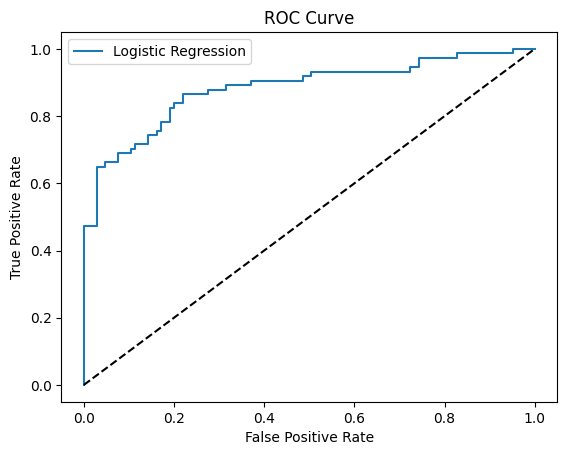

In [16]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()




In [25]:
# 8. Create SHAP values
# explainer = shap.LinearExplainer(model, X_train)
# shap_values = explainer.shap_values(X_test)

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

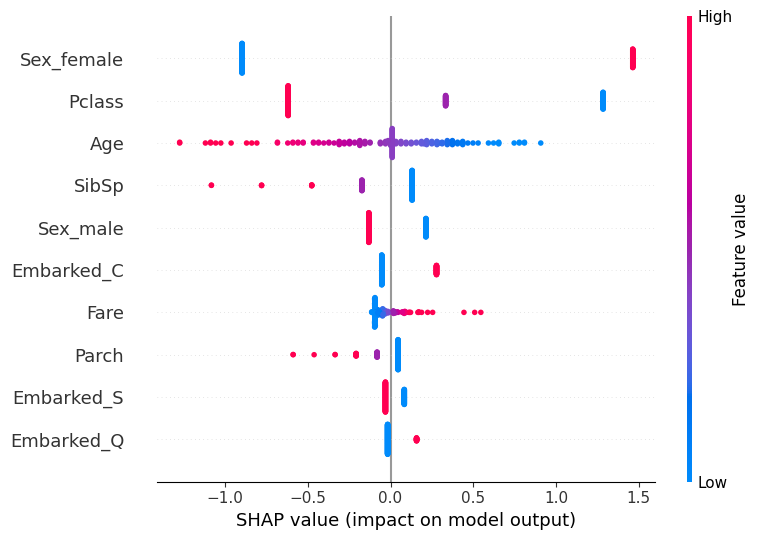

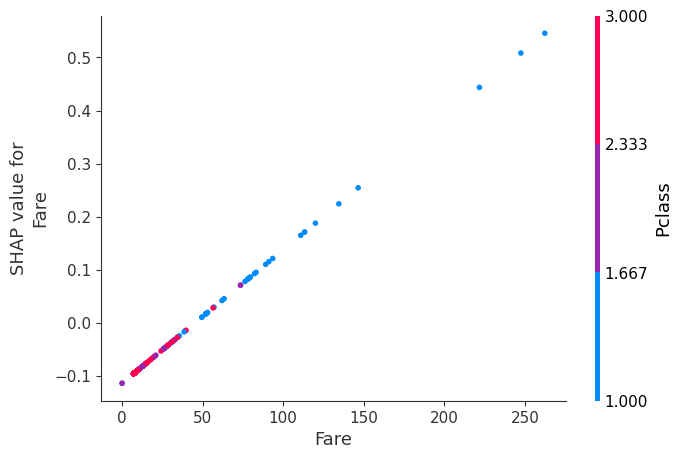

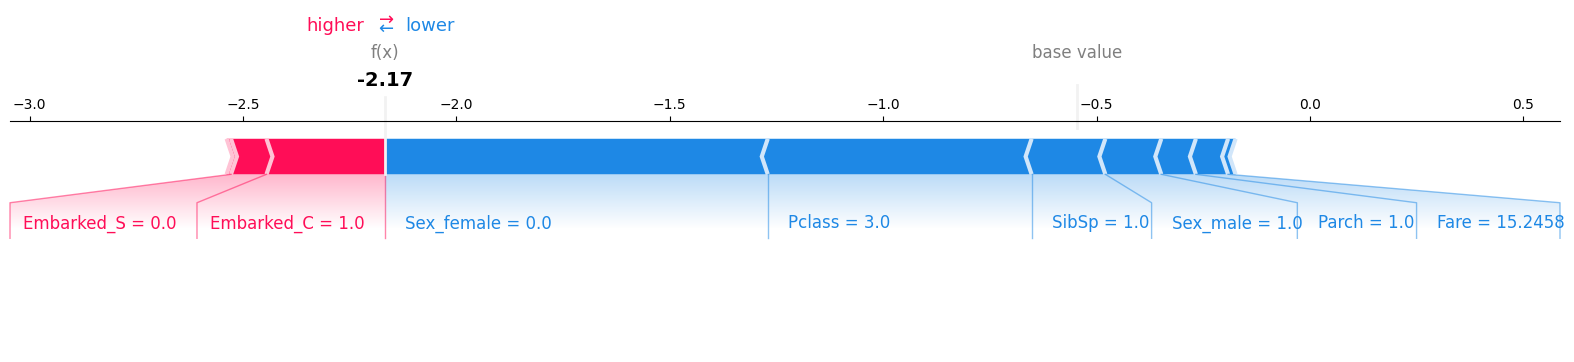

In [29]:
# # 9. Explain SHAP values
# shap.summary_plot(shap_values, X_test)
# shap.dependence_plot("Fare", shap_values, X_test)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
# 9. Explain SHAP values
# 8. Create SHAP values using the appropriate masker
X_train = X_train.astype(float)
X_test = X_test.astype(float)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 9. Explain SHAP values
shap.summary_plot(shap_values, X_test)
shap.dependence_plot("Fare", shap_values.values, X_test)
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test.iloc[0,:], matplotlib=True)